<a href="https://colab.research.google.com/github/erickamabilin/PDS_MAEPS/blob/main/CPT_MAEPS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>





   
# 1- Download, read and load the raw data



In [ ]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import psycopg2
import re

In [ ]:
!pip install gdown -q
!gdown --id 13NHW7x3PfT4URc8x0XSK9oZdNoebdrxS --output vw_cpt_brussels_params_completeset_20250318_remapped.parquet
raw = pd.read_parquet('vw_cpt_brussels_params_completeset_20250318_remapped.parquet')

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=13NHW7x3PfT4URc8x0XSK9oZdNoebdrxS
To: /content/vw_cpt_brussels_params_completeset_20250318_remapped.parquet
100% 64.6M/64.6M [00:01<00:00, 51.4MB/s]


In [ ]:
raw = raw.drop(['index','sondeernummer','pkey_sondering'], axis=1)

In [ ]:
raw.to_csv("cpt.csv", index=False)

Database


In [ ]:
# !pip -q install psycopg2-binary pandas python-dotenv

# ---------- 1) Connection (Supabase pooled port 6543 + SSL) ----------
user     = "postgres.vsqvzufrqjpjyulhetwl"
password = "MAEPSmaeps12345"
host     = "aws-1-eu-central-1.pooler.supabase.com"
port     = 6543
dbname   = "postgres"

def get_conn():
    return psycopg2.connect(
        host=host, port=port, dbname=dbname, user=user, password=password,
        sslmode="require"
    )

TABLE_STAGING = "stg_cpt_raw"

# ---------- 2) Sanitize columns (you already did this) ----------
def sanitize(name: str) -> str:
    s = re.sub(r'\s+', '_', str(name).strip())
    s = re.sub(r'[^0-9a-zA-Z_]', '_', s)
    if s and s[0].isdigit():
        s = '_' + s
    return s.lower()

raw = raw.copy()
orig2san, seen, new_cols = {}, set(), []
for c in raw.columns:
    base = sanitize(c)
    name = base
    i = 1
    while name in seen:
        name = f"{base}_{i}"; i += 1
    seen.add(name)
    orig2san[c] = name
    new_cols.append(name)
raw.columns = new_cols
print("Columns ->", raw.columns.tolist())

# ---------- 3) Create staging table ----------
ddl_cols = ",\n  ".join([f'"{c}" TEXT' for c in raw.columns])
ddl = f'CREATE TABLE IF NOT EXISTS {TABLE_STAGING} (\n  {ddl_cols}\n);'

with get_conn() as conn:
    conn.autocommit = True
    with conn.cursor() as cur:
        cur.execute(ddl)
print("Staging table ready.")


# ---------- 4) Bulk load DataFrame via COPY FROM STDIN ----------
cols_quoted = ", ".join([f'"{c}"' for c in raw.columns])
copy_sql = f"""
COPY {TABLE_STAGING} ({cols_quoted})
FROM STDIN WITH (FORMAT csv, HEADER true, DELIMITER ',', QUOTE '\"', NULL '');
"""

def copy_df(df_chunk: pd.DataFrame):
    buf = io.StringIO()
    df_chunk.to_csv(buf, index=False)  # header included
    buf.seek(0)
    with get_conn() as conn:
        with conn.cursor() as cur:
            cur.copy_expert(copy_sql, buf)
        conn.commit()

copy_df(raw)
print("Loaded DataFrame into staging table.")

# ---------- 5) Verify row count ----------
with get_conn() as conn:
    with conn.cursor() as cur:
        cur.execute(f"SELECT COUNT(*) FROM {TABLE_STAGING};")
        print("Rows in staging:", cur.fetchone()[0])

TYPED_TABLE = "cpt_brussels_params"
typed_sql = f"""
DROP TABLE IF EXISTS {TYPED_TABLE};
CREATE TABLE {TYPED_TABLE} AS
SELECT
  COALESCE(NULLIF(sondeernummer, ''), NULL)::text               AS sondeernummer,
  NULLIF(x, '')::double precision                               AS x,
  NULLIF(y, '')::double precision                               AS y,
  NULLIF(diepte_mtaw, '')::double precision                     AS diepte_mtaw,
  NULLIF(qc, '')::double precision                               AS qc,
  NULLIF(fs, '')::double precision                               AS fs,
  NULLIF(rf, '')::double precision                               AS rf
  -- TODO: add the rest of your columns with appropriate casts
FROM {TABLE_STAGING};

CREATE INDEX IF NOT EXISTS idx_{TYPED_TABLE}_sondeer ON {TYPED_TABLE}(sondeernummer);
CREATE INDEX IF NOT EXISTS idx_{TYPED_TABLE}_xy ON {TYPED_TABLE}(x, y);
"""


Columns -> ['sondering_id', 'x', 'y', 'start_sondering_mtaw', 'diepte_sondering_tot', 'diepte', 'diepte_mtaw', 'qc', 'fs', 'qtn', 'rf', 'fr', 'icn', 'sbt', 'ksbt', 'lithostrat_id']
Staging table ready.
Loaded DataFrame into staging table.
Rows in staging: 1222711


# Separate labeled and unlabeled data


In [ ]:
user     = "postgres.vsqvzufrqjpjyulhetwl"
password = "MAEPSmaeps12345"
host     = "aws-1-eu-central-1.pooler.supabase.com"
port     = 6543
dbname   = "postgres"

def get_conn():
    return psycopg2.connect(
        host=host, port=port, dbname=dbname, user=user, password=password,
        sslmode="require"
    )

query = "SELECT * FROM raw.labelled_cpt"

with get_conn() as conn:
    labeled_data = pd.read_sql(query, conn)

print("Data loaded from raw.labelled_cpt")
display(labeled_data.head())

/tmp/ipython-input-2580383783.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  labeled_data = pd.read_sql(query, conn)


Data loaded from raw.labelled_cpt


,sondering_id,x,y,start_sondering_mtaw,diepte_sondering_tot,diepte,diepte_mtaw,qc,fs,qtn,rf,fr,icn,sbt,ksbt,lithostrat_id
0,314,153278.2,181734.6,15.26,25.4,1.6,13.66,1.17,0.035,35.89400438353187,2.991452991452992,3.0583711988815097,2.56434,5.0,1.434e-07,Quartair
1,314,153278.2,181734.6,15.26,25.4,1.7,13.56,1.57,0.033,42.56231931660572,2.1019108280254777,2.1389681099299973,2.406724,5.0,4.321e-07,Quartair
2,314,153278.2,181734.6,15.26,25.4,1.8,13.459999999999999,1.43,0.036,38.53699112706456,2.5174825174825175,2.5692263773908075,2.491219,5.0,2.392e-07,Quartair
3,314,153278.2,181734.6,15.26,25.4,1.9,13.36,0.5,0.024,15.678500768214604,4.8,5.111165775078922,2.982185,3.0,7.7e-09,Quartair
4,314,153278.2,181734.6,15.26,25.4,2.0,13.26,1.33,0.023,33.203118561084175,1.7293233082706767,1.7721100750416183,2.440158,5.0,3.419e-07,Quartair


In [ ]:
numeric_cols = ['qc', 'fs', 'diepte']
labeled_data[numeric_cols] = labeled_data[numeric_cols].apply(pd.to_numeric, errors='coerce')

In [ ]:
# Check Missingness
labeled_data.describe(include='all')

,sondering_id,x,y,start_sondering_mtaw,diepte_sondering_tot,diepte,diepte_mtaw,qc,fs,qtn,rf,fr,icn,sbt,ksbt,lithostrat_id
count,225801,225801,225801,225801,225801,225801.000000,225801,225801.000000,225801.000000,225801,225801,225801,225752,225752,225752,214911
unique,242,242,242,236,180,NaN,34951,NaN,NaN,223091,164809,223086,207475,6,90928,29
top,4617,147757.5,177897.51,49.03,20.0,NaN,37.75,NaN,NaN,0.001,2.5,0.001,2.301816,5.0,4e-10,Quartair
freq,3141,3141,3141,3141,6083,NaN,41,NaN,NaN,49,231,49,5,96183,285,47285
mean,NaN,NaN,NaN,NaN,NaN,11.149534,NaN,7.915469,0.173368,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,7.307720,NaN,7.874764,0.177739,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,0.020000,NaN,0.001000,0.000054,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,5.290000,NaN,2.510000,0.059000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,9.850000,NaN,5.196000,0.106000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,15.840000,NaN,11.374000,0.235000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: >

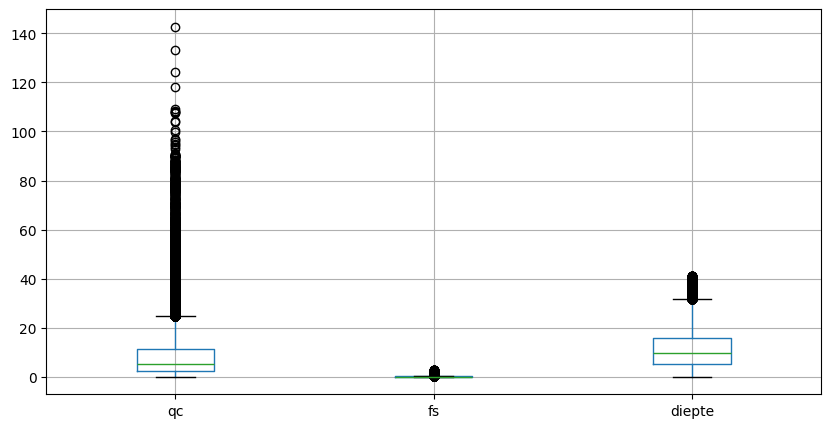

In [ ]:
# Check Range
labeled_data[numeric_cols].boxplot(figsize=(10, 5))

In [ ]:
# Add an ID column for lithostrat_id, only what we gathered from meeting (will add if file is uploaded)
layer_id = {'Aalbeke' : 1670,
'Asse' : 1410,
'Bolderberg' : 1121,
'Brussel' : 1480,
'Diest' : 1120,
'Kwatrecht' : 1540,
'Lede' : 1440,
'Merelbeke' : 1530,
'Mons_en_Pevele' : 1690,
'Mont_Panisel' : 1570,
'Orchies' : 1700,
'Quartair' : 1059,
'Sint_Huibrechts_Hern' : 1350,
'Ursel' : 1400,
'Wemmel' : 1420}

In [ ]:
# No ID number layers as -1
labeled_data['lithostrat_num'] = labeled_data['lithostrat_id'].map(layer_id).fillna(-1).astype(int)

In [ ]:
impt_layers_only = labeled_data[labeled_data['lithostrat_num'] != -1]

In [ ]:
dummies = pd.get_dummies(impt_layers_only['lithostrat_id'])
impt_layers_only = pd.concat([impt_layers_only, dummies], axis=1)

# Train, Test, Validation Datasets

In [ ]:
excluded_ids = {4629, 3892, 3675, 4455, 4859, 14000, 4449}
sondering_id = [i for i in labeled_data["sondering_id"].unique() if i not in excluded_ids]
train_sondering_id = [i for i in sondering_id[:int(len(sondering_id)*0.9)]]
test_sondering_id = [i for i in sondering_id if i not in train_sondering_id]
labeled_data.groupby("lithostrat_id").agg(distinct_sondering_id=('sondering_id', 'nunique'), total_records=('sondering_id', 'count'),id=('sondering_id','max')).sort_values(by='distinct_sondering_id')

,distinct_sondering_id,total_records,id
lithostrat_id,,,
Egemkapel,1,230,4629
Schelde Groep + Mons_en_Pevele,1,232,3892
Vlierzele,1,88,3675
Tertiair,1,278,4455
Quartair_Holoceen,1,902,4859
Onbekend + Mont_Panisel,1,850,14000
Orchies,1,250,4449
Egem,2,26,497
Tielt,2,223,3724


# Clean Data

In [ ]:
# Drop rows with any missing values in the labeled data
labeled_data = labeled_data.dropna()

X = labeled_data.drop('lithostrat_id', axis=1)
y = labeled_data['lithostrat_id']
x_train = X[X['sondering_id'].isin(train_sondering_id)]
x_test = X[X['sondering_id'].isin(test_sondering_id)]
y_train = y[X['sondering_id'].isin(train_sondering_id)]
y_test = y[X['sondering_id'].isin(test_sondering_id)]

print("Train-test split based on sondering_id complete.")
print(f"Training set shape: {x_train.shape}")
print(f"Test set shape: {x_test.shape}")

Train-test split based on sondering_id complete.
Training set shape: (161568, 15)
Test set shape: (46354, 15)


## Handling categorical data

In [ ]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

numerical_features = x_train.select_dtypes(include=['number']).columns.tolist()
numerical_features.remove('sondering_id')
categorical_features = x_train.select_dtypes(include=['object']).columns.tolist()
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

pipeline_lr = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', LogisticRegression(max_iter=1000))])

pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', RandomForestClassifier(random_state=0))])

pipeline_xgb = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=0))])

pipeline_gb = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', GradientBoostingClassifier(random_state=0))])

print("Logistic Regression Pipeline:")
display(pipeline_lr)

print("\nRandom Forest Pipeline:")
display(pipeline_rf)

print("\nXGBoost Pipeline:")
display(pipeline_xgb)

print("\nGradient Boosting Pipeline:")
display(pipeline_gb)

Logistic Regression Pipeline:


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['x', 'y',
                                                   'start_sondering_mtaw',
                                                   'diepte_sondering_tot',
                                                   'diepte', 'diepte_mtaw',
                                                   'qc', 'fs', 'qtn', 'rf',
                                                   'fr', 'icn', 'sbt',
                                                   'ksbt']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  [])])),
                ('classifier', LogisticRegression(max_iter=1000))])


Random Forest Pipeline:


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['x', 'y',
                                                   'start_sondering_mtaw',
                                                   'diepte_sondering_tot',
                                                   'diepte', 'diepte_mtaw',
                                                   'qc', 'fs', 'qtn', 'rf',
                                                   'fr', 'icn', 'sbt',
                                                   'ksbt']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  [])])),
                ('classifier', RandomForestClassifier(random_state=0))])


XGBoost Pipeline:


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['x', 'y',
                                                   'start_sondering_mtaw',
                                                   'diepte_sondering_tot',
                                                   'diepte', 'diepte_mtaw',
                                                   'qc', 'fs', 'qtn', 'rf',
                                                   'fr', 'icn', 'sbt',
                                                   'ksbt']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  [])])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_by...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])


Gradient Boosting Pipeline:


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['x', 'y',
                                                   'start_sondering_mtaw',
                                                   'diepte_sondering_tot',
                                                   'diepte', 'diepte_mtaw',
                                                   'qc', 'fs', 'qtn', 'rf',
                                                   'fr', 'icn', 'sbt',
                                                   'ksbt']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  [])])),
                ('classifier', GradientBoostingClassifier(random_state=0))])

In [ ]:
from sklearn.preprocessing import LabelEncoder

print("Training Logistic Regression...")
pipeline_lr.fit(x_train, y_train)
print("Logistic Regression training complete.")

print("\nTraining Random Forest...")
pipeline_rf.fit(x_train, y_train)
print("Random Forest training complete.")

print("\nTraining XGBoost...")
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
pipeline_xgb.fit(x_train, y_train_encoded)
print("XGBoost training complete.")

# print("\nTraining Gradient Boosting...")
# pipeline_gb.fit(x_train, y_train)
# print("Gradient Boosting training complete.")

Training Logistic Regression...
Logistic Regression training complete.

Training Random Forest...
Random Forest training complete.

Training XGBoost...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [13:12:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost training complete.


In [ ]:
from sklearn.utils import shuffle

# Shuffle the test set while keeping features and target aligned
x_test_shuffled, y_test_shuffled = shuffle(x_test, y_test, random_state=0)

print("Test set has been shuffled.")

Test set has been shuffled.


In [ ]:
# Evaluate each model on the test set
score_lr = pipeline_lr.score(x_test_shuffled, y_test_shuffled)

score_rf = pipeline_rf.score(x_test_shuffled, y_test_shuffled)

y_test_encoded = label_encoder.transform(y_test_shuffled)
score_xgb = pipeline_xgb.score(x_test_shuffled, y_test_encoded)

# score_gb = pipeline_gb.score(x_test_shuffled, y_test_shuffled)

print(f'Logistic Regression Test Set Accuracy: {score_lr:.2f}')
print(f'Random Forest Test Set Accuracy: {score_rf:.2f}')
print(f'XGBoost Test Set Accuracy: {score_xgb:.2f}')
# print(f'Gradient Boosting Test Set Accuracy: {score_gb:.2f}')

Logistic Regression Test Set Accuracy: 0.40
Random Forest Test Set Accuracy: 0.22
XGBoost Test Set Accuracy: 0.19


In [ ]:
import pickle

filename_lr = 'logistic_regression_pipeline.pkl'
filename_rf = 'random_forest_pipeline.pkl'
filename_xgb = 'xgboost_pipeline.pkl'
filename_gb = 'gradient_boosting_pipeline.pkl'

with open(filename_lr, 'wb') as f:
    pickle.dump(pipeline_lr, f)
print(f"Logistic Regression pipeline saved to {filename_lr}")

with open(filename_rf, 'wb') as f:
    pickle.dump(pipeline_rf, f)
print(f"Random Forest pipeline saved to {filename_rf}")

with open(filename_xgb, 'wb') as f:
    pickle.dump(pipeline_xgb, f)
print(f"XGBoost pipeline saved to {filename_xgb}")

with open(filename_gb, 'wb') as f:
    pickle.dump(pipeline_gb, f)
print(f"Gradient Boosting pipeline saved to {filename_gb}")

Logistic Regression pipeline saved to logistic_regression_pipeline.pkl
Random Forest pipeline saved to random_forest_pipeline.pkl
XGBoost pipeline saved to xgboost_pipeline.pkl
Gradient Boosting pipeline saved to gradient_boosting_pipeline.pkl
